In [2]:
import os 

cwd = os.getcwd()

print("Current working directory: {0}".format(cwd))

print ("os.getcwd() returns an object of type {0}".format(type(cwd)))

#copy the filepath 
os.chdir("C:/Users/eotie/Downloads")

Current working directory: C:\Users\eotie
os.getcwd() returns an object of type <class 'str'>


C:\Users\eotie\AppData\Local\Temp\ipykernel_179820\411221736.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  date_time = pd.to_datetime(date_time)
C:\Users\eotie\AppData\Local\Temp\ipykernel_179820\411221736.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])


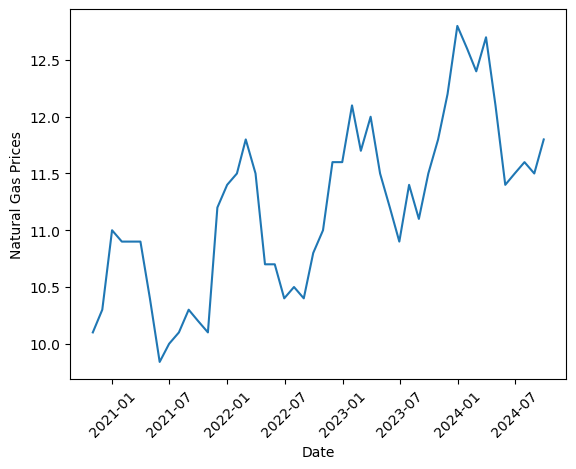

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

date_time =["10-2020", "11-2020","12-2020"]
date_time = pd.to_datetime(date_time)
data =[1,2,3]

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# plot prices against dates 
fig, ax = plt.subplots()
ax.plot(dates, prices, '-')
ax.set_xlabel('Date')
ax.set_ylabel('Natural Gas Prices')
ax.tick_params(axis='x', rotation=45)

plt.show()

In [ ]:
#From the plot we can see that prices have a natural one year frequency, with prices, which are trending upwards, peaking in the winter months and dipping in the summer months.
#We do a linear regeression to model the trend and a fourier series(fit a sin function) to model the seasonality.

#First we create variables that represent the start date and end date to make it easier to interpolate later on.
def generate_month_list():
    start_date = date (2020,10,31)
    end_date = date (2024,9,30)
    months =[]
    year = start_date.year
    month = start_date.month + 1
    while True:
        current = date (year, month, 1) + timedelta(days=-1)
        months.append (current)
        if current.month == end_date.month and current.year == end_date.year:
            break
        else :
            month = ((month + 1) % 12) or 12 
            if month == 1:
                year += 1

    days_from_start = [(day-start_date).days for day in months]

interpolate()